# Findings 5
Dated: 30.06.2025

# imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd

# Get the notebook's current directory
notebook_dir = os.getcwd()

# Move one level up to get the parent directory
parent_dir = os.path.dirname(notebook_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from module import *

/opt/anaconda3/envs/cqr/lib/python3.11/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/opt/anaconda3/envs/cqr/lib/python3.11/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# computation device
This variable sets the device to be used for the Neural Network trainings:

In [2]:
computation_device = 'auto'

# system init
This is a generic spring damper setup. Very simple and linear, with two states and one input. The state euation is the force balance of a spring damper.

In [3]:
cstr_system = CSTR_dompc(set_seed=0)

Modifying constraints

In [4]:
#spring_system.lbu = np.array([-10])       # [lower_bound_f_ext]
#spring_system.ubu = np.array([10])        # [upper_bound_f_ext]

# surrogate generator init
This class is designed to be totally generic, i.e., it can take any do-mpc model, or at least that is the idea.

In [5]:
dm = DataManager(set_seed=0)

# random data

Here we generate sampled with one random initial point and random inputs. Then the data and the data is split randomly to feed different parts of the algorithm.
There is another alternate algorithm which generates data by chasing random setpoints with the help of an MPC controller.

In [6]:
dm.random_input_sampler(system = cstr_system, n_samples=1000)
dm.data_splitter(order=1, narx_train= 0.3, cqr_train= 0.3, cqr_calibration= 0.3, test = 0.1)
#dm.data_splitter(order=2)

Generating data: 100%|██████████| 1000/1000 [00:00<00:00, 3155.84it/s]


## data visualisation

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_graphics.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


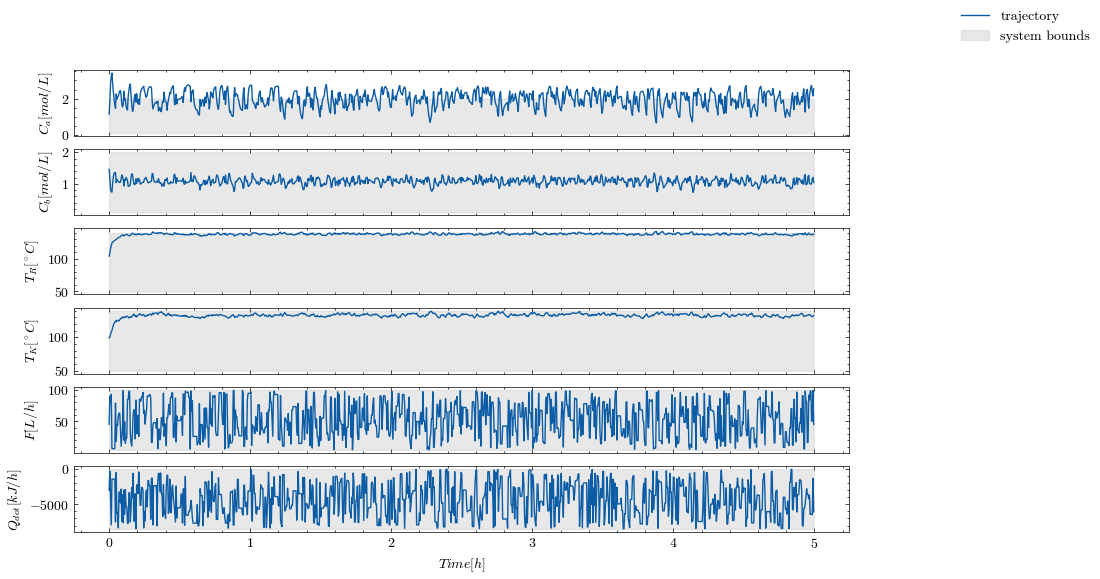

In [7]:
#dm.visualize_data()
dm.plot_simulation(system=cstr_system, simulator=dm.data['sampler'], figsize=(10, 6), fig_name='r1_simulation.pdf')

# NARX model

Training NARX: 100%|██████████| 1000/1000 [00:01<00:00, 854.47it/s]
/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_narx.py:228: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


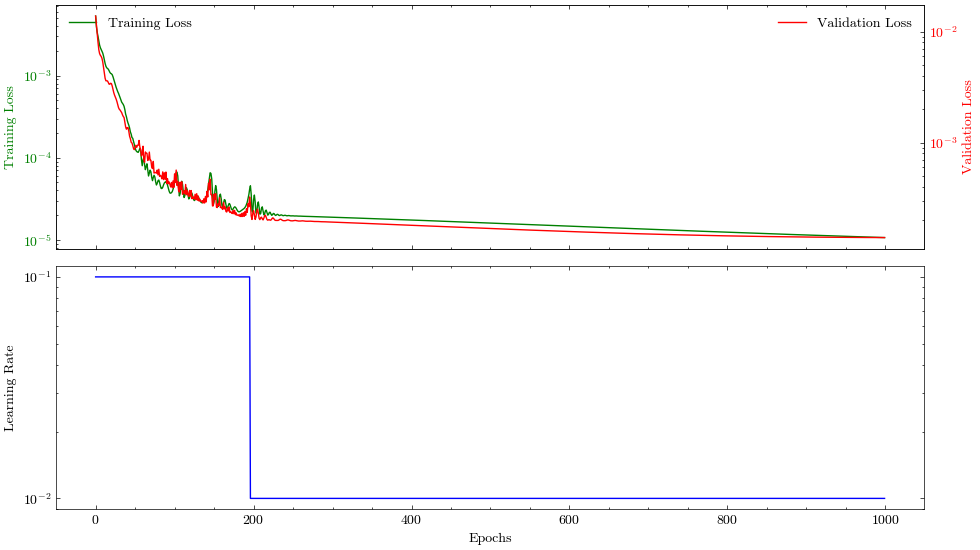

In [8]:
dm.train_narx(hidden_layers=[5], batch_size=1000,
          learning_rate=0.1, epochs= 1000, scheduler_flag=True, device=computation_device, train_threshold=1e-6)
dm.narx.plot_narx_training_history()

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_narx.py:264: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


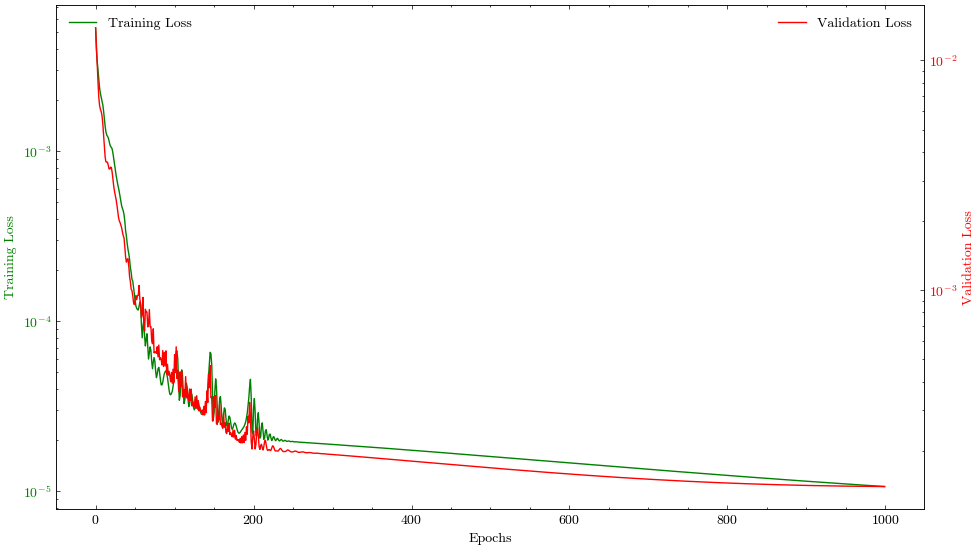

In [9]:
dm.narx.plot_loss_history(fig_name='r1_narx_loss.pdf')

# conformal quantile regression
Here qunatile regression is done to bound the errors with confidence values

Training Cqr q= 0.025: 100%|██████████| 1000/1000 [00:01<00:00, 939.62it/s]


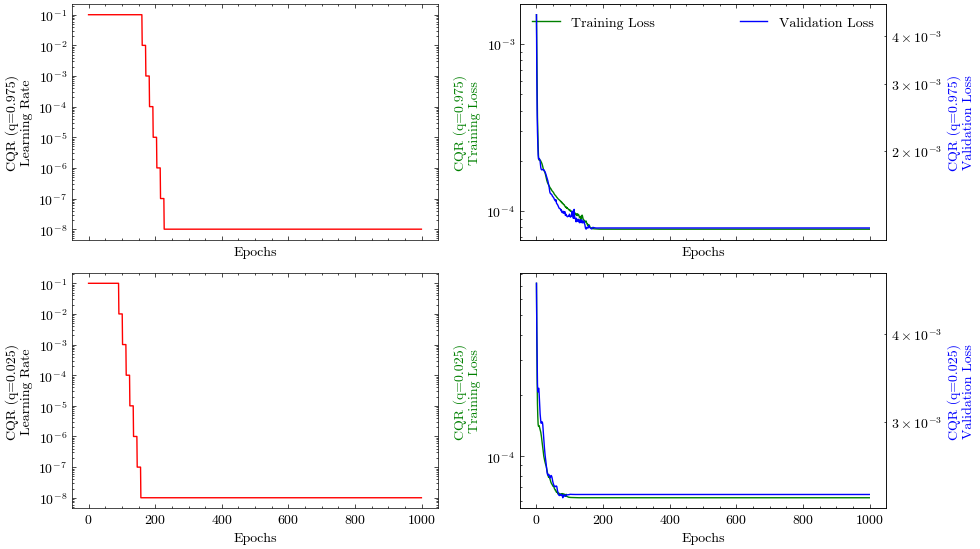

In [10]:
dm.train_cqr(alpha=0.05, hidden_layers=[3],  epochs= 1000, batch_size=1000, 
             device=computation_device, train_threshold=1e-20)
dm.cqr.plot_qr_training_history()

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_cqr.py:1266: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


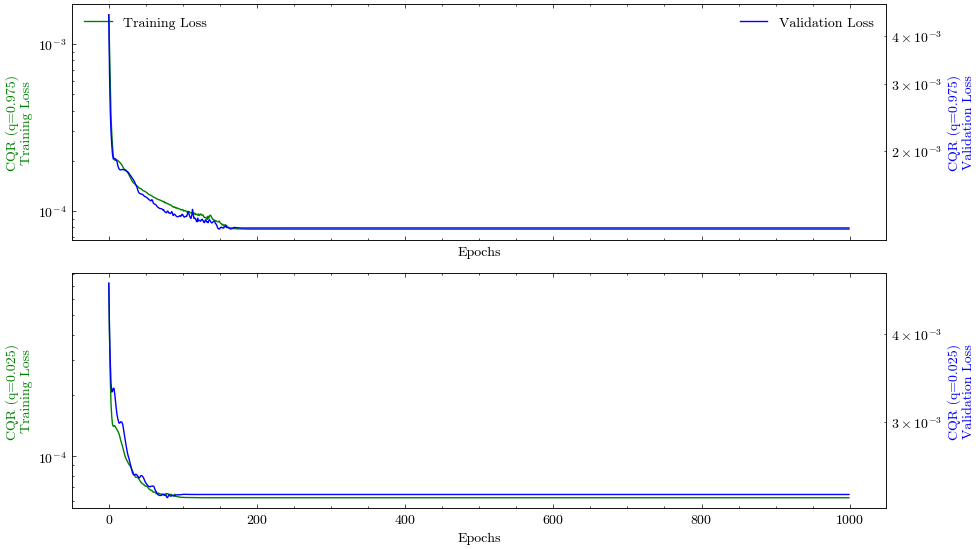

In [11]:
dm.cqr.plot_loss_history(fig_name='r1_cqr_loss.pdf')

This section visualises the quantile regression on the calibration data which the regressors has yet not seen.

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_cqr.py:793: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


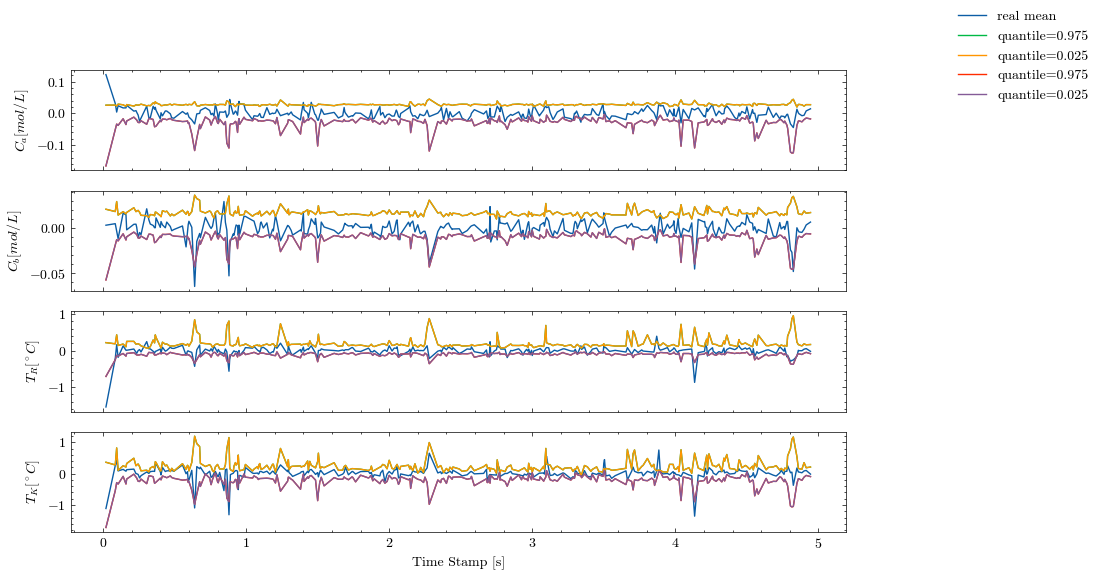

In [12]:
dm.cqr_plot_qr_error_matplotlib(system=cstr_system, fig_name='r1_qr_error.pdf')

This plot is made against test data which till now is untouched.

In [13]:
dm.cqr_plot_qr_error()

In [14]:
dm.plot_cqr_error_plotly()

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_cqr.py:976: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



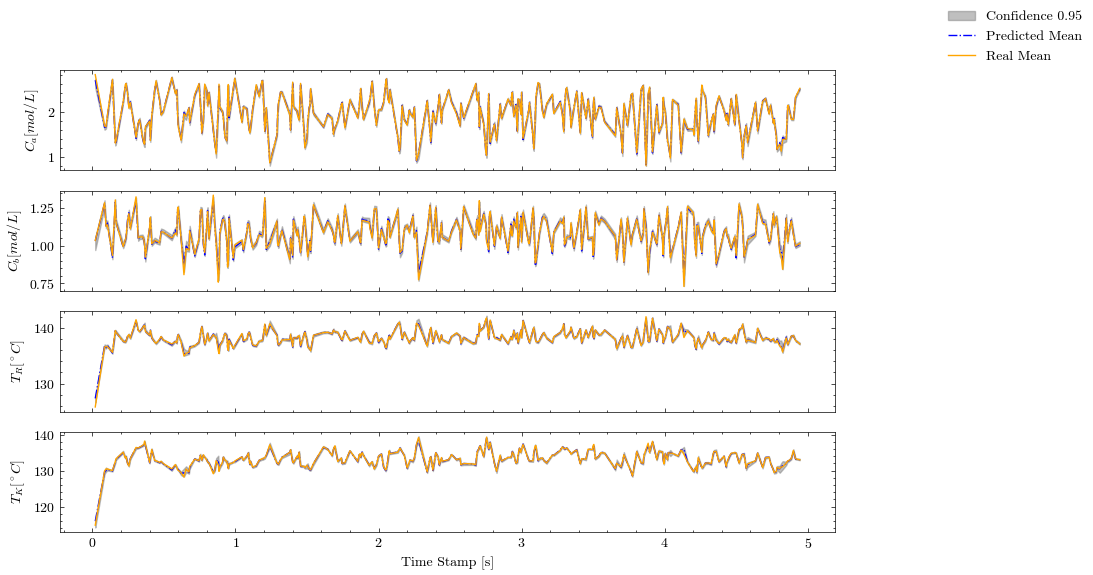

In [15]:
dm.plot_cqr_error_matplotlib(system=cstr_system, fig_name='r1_cqr_error_matplotlib.pdf')

# verifying simulator performance

In [16]:
# checking simulator performance
C_a0 = 0.8 # This is the initial concentration inside the tank [mol/l]
C_b0 = 0.5 # This is the controlled variable [mol/l]
T_R0 = 134.14 #[C]
T_K0 = 130.0 #[C]

#C_a0 = 0
#C_b0 = 0
#T_R0 = 387.05
#T_J0 = 387.05

x_init = np.array([[C_a0, C_b0, T_R0, T_K0]])
dm.check_simulator(system=cstr_system, iter= 50, x_init=x_init)



-------- Pytorch NARX Model -> do-mpc model --------

state_1_lag_0 <<--- @1=((state_1_lag_0-1.99805)/0.445503), @2=((state_2_lag_0-1.085)/0.102507), @3=((state_3_lag_0-138.031)/2.66284), @4=((state_4_lag_0-132.837)/3.44518), @5=((input_1_lag_0-52.7393)/27.14), @6=((input_2_lag_0--4538.43)/2310.09), @7=(((((((0.115203*@1)+(0.0486562*@2))+(0.110991*@3))+(-0.261673*@4))+(-0.0730828*@5))+(-0.126166*@6))+0.000999569), @8=(((((((-0.144465*@1)+(-0.0569667*@2))+(0.301905*@3))+(0.00116106*@4))+(-0.222288*@5))+(-0.00546537*@6))+1.31389), @9=(((((((-0.186851*@1)+(-0.0136669*@2))+(0.201029*@3))+(0.0257019*@4))+(-0.337712*@5))+(-0.00541204*@6))+-0.767057), @10=(((((((-0.256404*@1)+(-0.185554*@2))+(-0.016732*@3))+(-0.110184*@4))+(0.175296*@5))+(-0.0392101*@6))+0.125914), @11=(((((((-0.104112*@1)+(0.0581645*@2))+(-0.173972*@3))+(0.0304031*@4))+(-0.182004*@5))+(0.0182237*@6))+-0.408386), ((0.434075*((((((-0.0583358*((exp(@7)-exp((-@7)))/(exp(@7)+exp((-@7)))))+(-1.9959*((exp(@8)-exp((-@8)))/(exp(@8)

## reference check
This function plots the performance of an MPC with a surrogate model.

In [17]:
iter = 50
setpoint = None
n_horizon = 20
r = 0.1



-------- Pytorch NARX Model -> do-mpc model --------

state_1_lag_0 <<--- @1=((state_1_lag_0-1.99805)/0.445503), @2=((state_2_lag_0-1.085)/0.102507), @3=((state_3_lag_0-138.031)/2.66284), @4=((state_4_lag_0-132.837)/3.44518), @5=((input_1_lag_0-52.7393)/27.14), @6=((input_2_lag_0--4538.43)/2310.09), @7=(((((((0.115203*@1)+(0.0486562*@2))+(0.110991*@3))+(-0.261673*@4))+(-0.0730828*@5))+(-0.126166*@6))+0.000999569), @8=(((((((-0.144465*@1)+(-0.0569667*@2))+(0.301905*@3))+(0.00116106*@4))+(-0.222288*@5))+(-0.00546537*@6))+1.31389), @9=(((((((-0.186851*@1)+(-0.0136669*@2))+(0.201029*@3))+(0.0257019*@4))+(-0.337712*@5))+(-0.00541204*@6))+-0.767057), @10=(((((((-0.256404*@1)+(-0.185554*@2))+(-0.016732*@3))+(-0.110184*@4))+(0.175296*@5))+(-0.0392101*@6))+0.125914), @11=(((((((-0.104112*@1)+(0.0581645*@2))+(-0.173972*@3))+(0.0304031*@4))+(-0.182004*@5))+(0.0182237*@6))+-0.408386), ((0.434075*((((((-0.0583358*((exp(@7)-exp((-@7)))/(exp(@7)+exp((-@7)))))+(-1.9959*((exp(@8)-exp((-@8)))/(exp(@8)

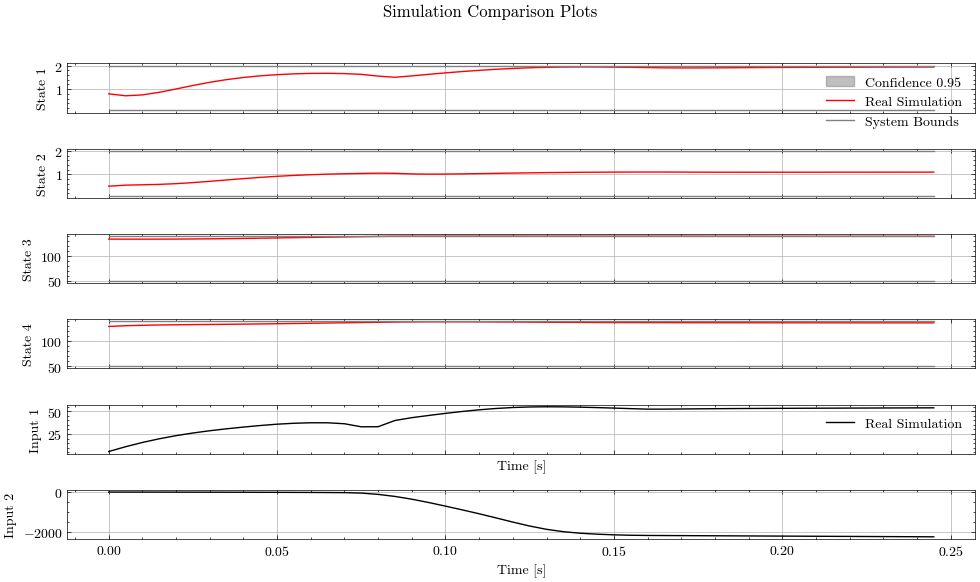

In [18]:
# check closed loop performance for an MPC with a surrogate model, simulated on the real system
dm.check_simulator_mpc(system=cstr_system, iter=iter, setpoint=setpoint, n_horizon=n_horizon, r=r, x_init=x_init)

# case study 1
This is the main investigative case study of my Thesis. In ths case study the surrogate (NARX) model is used in the MPC. An outer loop consists of the CQR model, which is used to propagate the uncertainty. If due to the uncertatinty, the system boundaries are violated, in that case boundaries are constricted.

In [19]:
# run the icb_mpc
lqr_r = 75
lqr_q = 1
R = lqr_r*np.array([[1/(95*95), 0],
              [0, 1/(8500*8500)]])
Q = lqr_q*np.array([[1/(1.9*1.9), 0, 0, 0],
              [0, 1/(1.9*1.9), 0, 0],
              [0, 0, 1/(90*90), 0],
              [0, 0, 0, 1/(90*90)]])
tightner = 1.5
confidence_cutoff = 0.8
rnd_samples = 7
max_search = 10
results_dicts = []

In [20]:
cs1 = dm.case_study_1(system=cstr_system, iter=iter, setpoint=setpoint,
                  n_horizon=n_horizon, r=r,
                  tightner=tightner, confidence_cutoff=confidence_cutoff, 
                  rnd_samples=rnd_samples, max_search=max_search, R=R, Q=Q,
                  x_init = x_init, store_gif=False)
cs1['LQR r'] = lqr_r
cs1['LQR q'] = lqr_q
results_dicts.append(cs1)



-------- Pytorch NARX Model -> do-mpc model --------

state_1_lag_0 <<--- @1=((state_1_lag_0-1.99805)/0.445503), @2=((state_2_lag_0-1.085)/0.102507), @3=((state_3_lag_0-138.031)/2.66284), @4=((state_4_lag_0-132.837)/3.44518), @5=((input_1_lag_0-52.7393)/27.14), @6=((input_2_lag_0--4538.43)/2310.09), @7=(((((((0.115203*@1)+(0.0486562*@2))+(0.110991*@3))+(-0.261673*@4))+(-0.0730828*@5))+(-0.126166*@6))+0.000999569), @8=(((((((-0.144465*@1)+(-0.0569667*@2))+(0.301905*@3))+(0.00116106*@4))+(-0.222288*@5))+(-0.00546537*@6))+1.31389), @9=(((((((-0.186851*@1)+(-0.0136669*@2))+(0.201029*@3))+(0.0257019*@4))+(-0.337712*@5))+(-0.00541204*@6))+-0.767057), @10=(((((((-0.256404*@1)+(-0.185554*@2))+(-0.016732*@3))+(-0.110184*@4))+(0.175296*@5))+(-0.0392101*@6))+0.125914), @11=(((((((-0.104112*@1)+(0.0581645*@2))+(-0.173972*@3))+(0.0304031*@4))+(-0.182004*@5))+(0.0182237*@6))+-0.408386), ((0.434075*((((((-0.0583358*((exp(@7)-exp((-@7)))/(exp(@7)+exp((-@7)))))+(-1.9959*((exp(@8)-exp((-@8)))/(exp(@8)

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_graphics.py:199: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



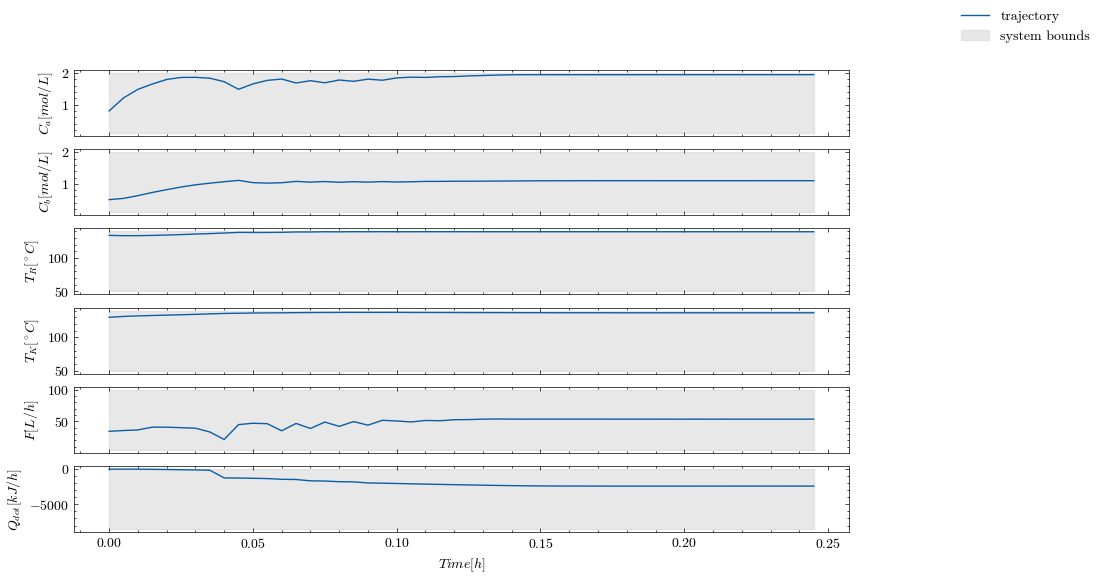

In [21]:
dm.plot_simulation(system=cstr_system, simulator=dm.simulation['cs1'], figsize=(10, 6))

In [22]:
#dm.show_gif_matplotlib(system = cstr_system, gif_name="matplotlib_animation_cs1.gif")

# case study 2
In this case study, all the data used for the cqr is used to create another surrogate model, which should perform better thant the previous surrogate model as it has seen lower amount of data. With this argument I want to prove that I cases where the models are data starved, it is better to split the data and use my algo (case study 1), as it will at least prevent boundary violation, which is still a possibly in case of a marginally better model.

Training NARX: 100%|██████████| 1000/1000 [00:03<00:00, 274.72it/s]
/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_narx.py:228: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_narx.py:264: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown





-------- Pytorch NARX Model -> do-mpc model --------

state_1_lag_0 <<--- @1=((state_1_lag_0-1.96783)/0.437266), @2=((state_2_lag_0-1.08271)/0.107552), @3=((state_3_lag_0-138.06)/2.38554), @4=((state_4_lag_0-132.941)/3.15599), @5=((input_1_lag_0-53.0044)/27.5118), @6=((input_2_lag_0--4352.71)/2394.41), @7=(((((((0.263627*@1)+(0.107119*@2))+(0.0924174*@3))+(0.129976*@4))+(0.00741905*@5))+(0.105296*@6))+1.28113), @8=((exp(@7)-exp((-@7)))/(exp(@7)+exp((-@7)))), @9=(((((((-0.177931*@1)+(-0.0798176*@2))+(0.0559435*@3))+(0.0668025*@4))+(-0.0596635*@5))+(0.0228669*@6))+0.0189402), @10=((exp(@9)-exp((-@9)))/(exp(@9)+exp((-@9)))), @11=(((((((0.0636135*@1)+(0.148726*@2))+(-0.217447*@3))+(0.281242*@4))+(0.0598293*@5))+(0.0636627*@6))+-0.0511616), @12=((exp(@11)-exp((-@11)))/(exp(@11)+exp((-@11)))), @13=(((((((-0.110745*@1)+(-0.111571*@2))+(-0.127315*@3))+(0.0359206*@4))+(0.245036*@5))+(0.0210524*@6))+0.364542), @14=((exp(@13)-exp((-@13)))/(exp(@13)+exp((-@13)))), @15=(((((((-0.254055*@1)+(0.016

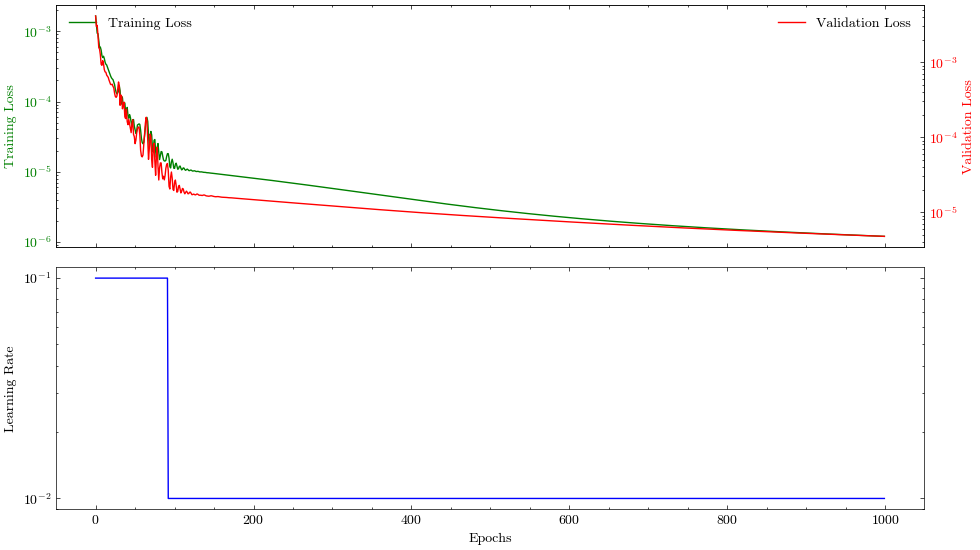

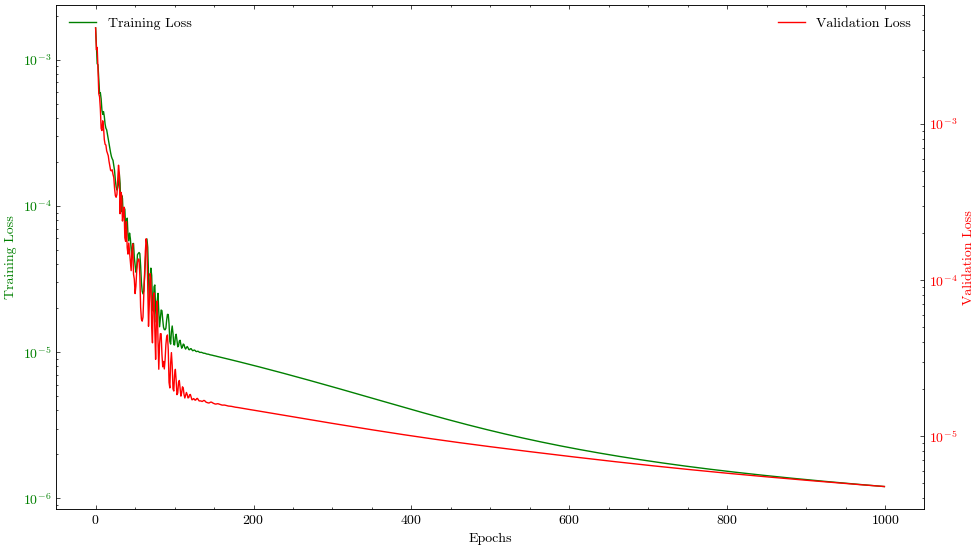

In [23]:
dm.setup_case_study_2(hidden_layers=[10, 10], system=cstr_system, setpoint=setpoint, 
                      n_horizon=n_horizon, r=r, epochs=1000, batch_size=1000)

In [24]:
cs2 = dm.case_study_2(system=cstr_system, iter = iter, x_init=x_init)
results_dicts.append(cs2)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      564
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      458

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      116
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0244975e+01 6.18e-01 9.82e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_graphics.py:199: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



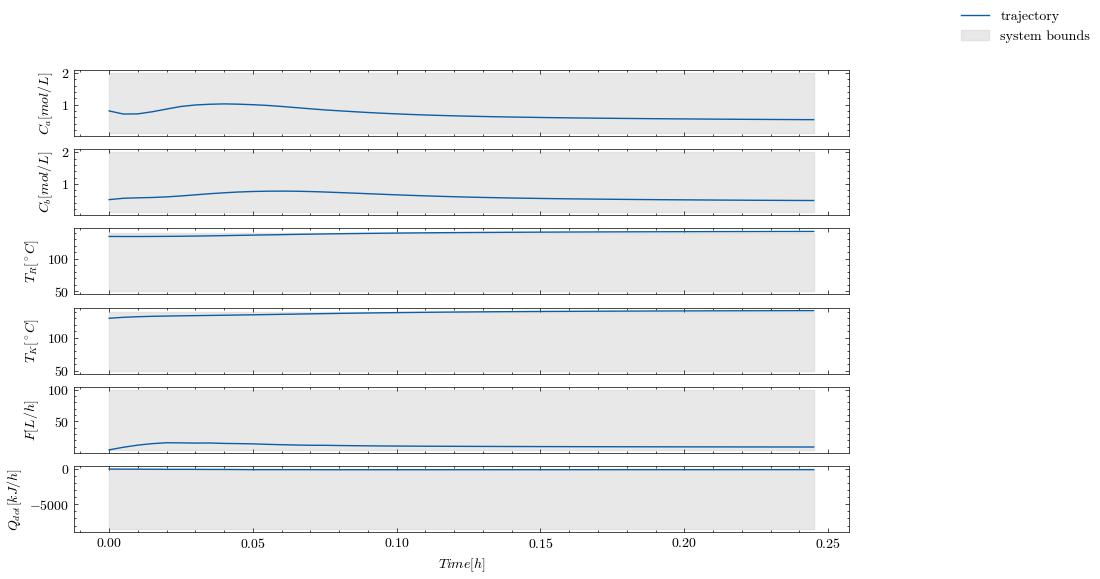

In [25]:
dm.plot_simulation(system=cstr_system, simulator=dm.simulation['cs2'], figsize=(10, 6))

# case study 3
surrogate model with Multi-stage robust mpc.


In [26]:
r_horizon = 5
dm.setup_case_study_3(system=cstr_system, n_horizon=n_horizon, r_horizon=r_horizon, r=r, setpoint=setpoint)
cs3 = dm.case_study_3(system=cstr_system, iter=iter, x_init=x_init)
results_dicts.append(cs3)



-------- Pytorch NARX Model -> do-mpc model --------

state_1_lag_0 <<--- @1=((state_1_lag_0-1.99805)/0.445503), @2=((state_2_lag_0-1.085)/0.102507), @3=((state_3_lag_0-138.031)/2.66284), @4=((state_4_lag_0-132.837)/3.44518), @5=((input_1_lag_0-52.7393)/27.14), @6=((input_2_lag_0--4538.43)/2310.09), @7=(((((((0.115203*@1)+(0.0486562*@2))+(0.110991*@3))+(-0.261673*@4))+(-0.0730828*@5))+(-0.126166*@6))+0.000999569), @8=(((((((-0.144465*@1)+(-0.0569667*@2))+(0.301905*@3))+(0.00116106*@4))+(-0.222288*@5))+(-0.00546537*@6))+1.31389), @9=(((((((-0.186851*@1)+(-0.0136669*@2))+(0.201029*@3))+(0.0257019*@4))+(-0.337712*@5))+(-0.00541204*@6))+-0.767057), @10=(((((((-0.256404*@1)+(-0.185554*@2))+(-0.016732*@3))+(-0.110184*@4))+(0.175296*@5))+(-0.0392101*@6))+0.125914), @11=(((((((-0.104112*@1)+(0.0581645*@2))+(-0.173972*@3))+(0.0304031*@4))+(-0.182004*@5))+(0.0182237*@6))+-0.408386), @12=1, @13=2, @14=0.054832, @15=1.96726, @16=0.433535, @17=((state_1_lag_0-@15)/@16), @18=1.08039, @19=0.10966, 

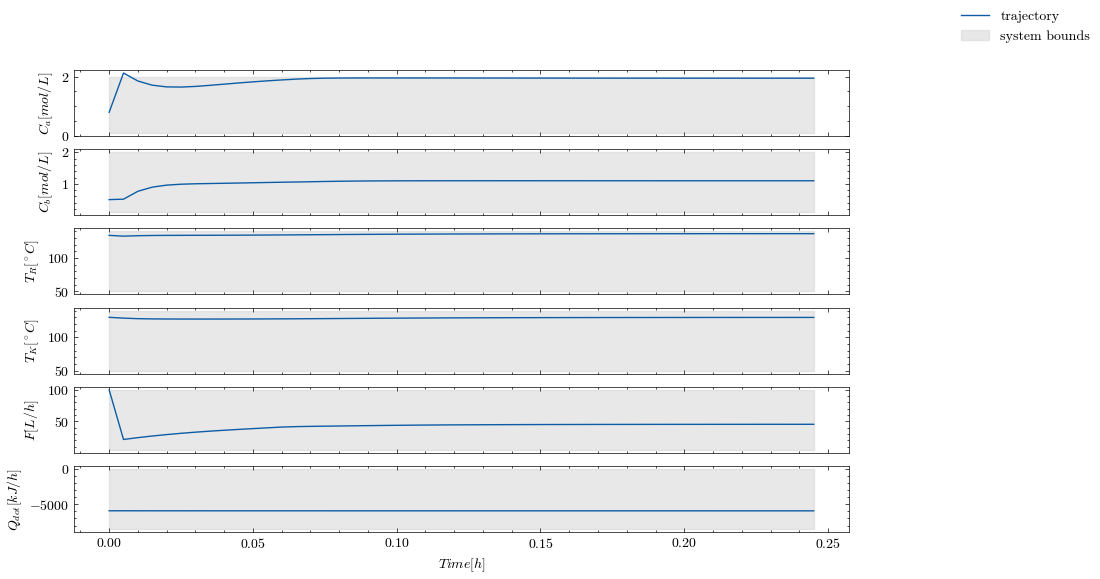

In [27]:
dm.plot_simulation(system=cstr_system, simulator=dm.simulation['cs3'], figsize=(10, 6))

# case study 4
real model with real mpc. This is the benchmark.

In [28]:
dm.setup_case_study_4(system=cstr_system, n_horizon=n_horizon, r=r, setpoint=setpoint)
cs4 = dm.case_study_4(system=cstr_system, iter=iter, x_init=x_init)
results_dicts.append(cs4)

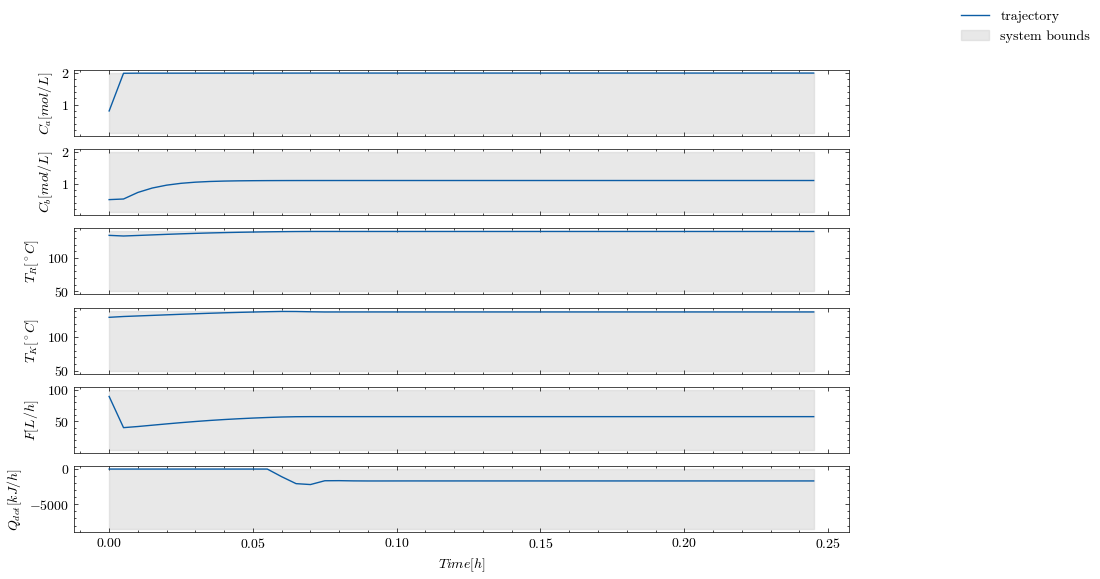

In [29]:
dm.plot_simulation(system=cstr_system, simulator=dm.simulation['cs4'], figsize=(10, 6))

# case study 5 (EXTRA)
This is the midterm algo.

In [30]:
cs5 = dm.case_study_5(system=cstr_system, iter=iter, setpoint=setpoint,
                  n_horizon=n_horizon, r=r,
                  tightner=tightner, confidence_cutoff=confidence_cutoff, rnd_samples=rnd_samples, max_search=max_search,
                  x_init = x_init, store_gif=False)
results_dicts.append(cs5)



-------- Pytorch NARX Model -> do-mpc model --------

state_1_lag_0 <<--- @1=((state_1_lag_0-1.99805)/0.445503), @2=((state_2_lag_0-1.085)/0.102507), @3=((state_3_lag_0-138.031)/2.66284), @4=((state_4_lag_0-132.837)/3.44518), @5=((input_1_lag_0-52.7393)/27.14), @6=((input_2_lag_0--4538.43)/2310.09), @7=(((((((0.115203*@1)+(0.0486562*@2))+(0.110991*@3))+(-0.261673*@4))+(-0.0730828*@5))+(-0.126166*@6))+0.000999569), @8=(((((((-0.144465*@1)+(-0.0569667*@2))+(0.301905*@3))+(0.00116106*@4))+(-0.222288*@5))+(-0.00546537*@6))+1.31389), @9=(((((((-0.186851*@1)+(-0.0136669*@2))+(0.201029*@3))+(0.0257019*@4))+(-0.337712*@5))+(-0.00541204*@6))+-0.767057), @10=(((((((-0.256404*@1)+(-0.185554*@2))+(-0.016732*@3))+(-0.110184*@4))+(0.175296*@5))+(-0.0392101*@6))+0.125914), @11=(((((((-0.104112*@1)+(0.0581645*@2))+(-0.173972*@3))+(0.0304031*@4))+(-0.182004*@5))+(0.0182237*@6))+-0.408386), ((0.434075*((((((-0.0583358*((exp(@7)-exp((-@7)))/(exp(@7)+exp((-@7)))))+(-1.9959*((exp(@8)-exp((-@8)))/(exp(@8)

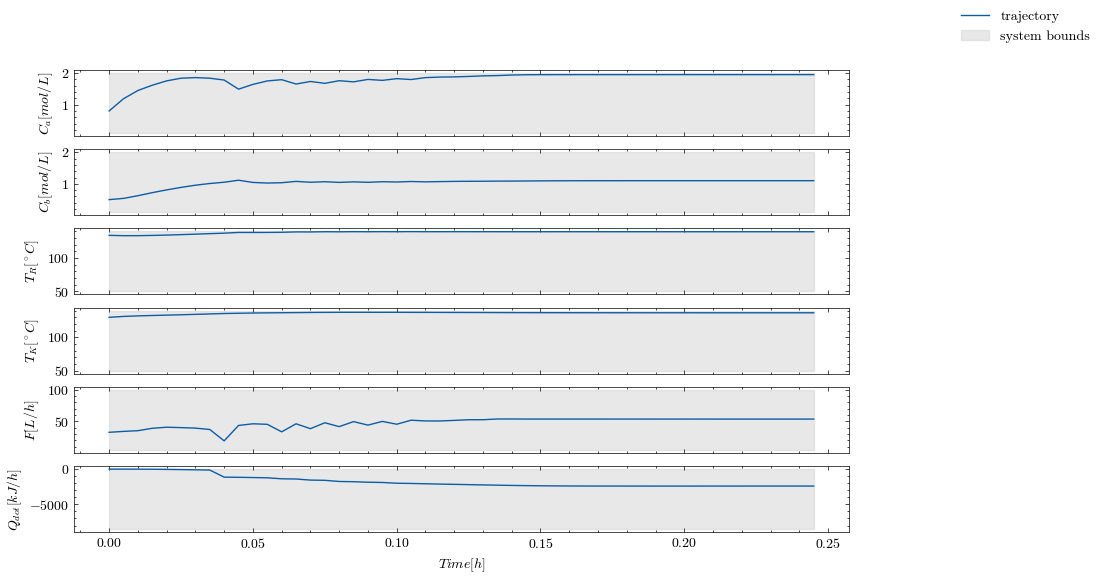

In [31]:
dm.plot_simulation(system=cstr_system, simulator=dm.simulation['cs5'], figsize=(10, 6))

In [32]:
#dm.show_gif_matplotlib(system=cstr_system, gif_name="matplotlib_animation_cs5.gif")

# result management

In [33]:
filename = 'results_plot.csv'

try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    df = pd.DataFrame()

# check if df is empty, assign a new column name 'Serial No.' and add it to all dicts
if df.empty:
    for i, result_dict in enumerate(results_dicts, start=1):
        result_dict['Serial No.'] = i

# df is not empty, assign the next serial number
else:
    last_serial_no = df['Serial No.'].max()
    for result_dict in results_dicts:
        last_serial_no += 1
        result_dict['Serial No.'] = last_serial_no

# Convert the list of dictionaries to a DataFrame
new_df = pd.DataFrame(results_dicts)

# put the 'Serial No.' as the first column
new_df = new_df[['Serial No.'] + [col for col in new_df.columns if col != 'Serial No.']]

# Append the new DataFrame to the existing one
df = pd.concat([df, new_df], ignore_index=True)

# Save the updated DataFrame to the CSV file
df.to_csv(filename, index=False)

# combined plot

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_datamanager.py:1653: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



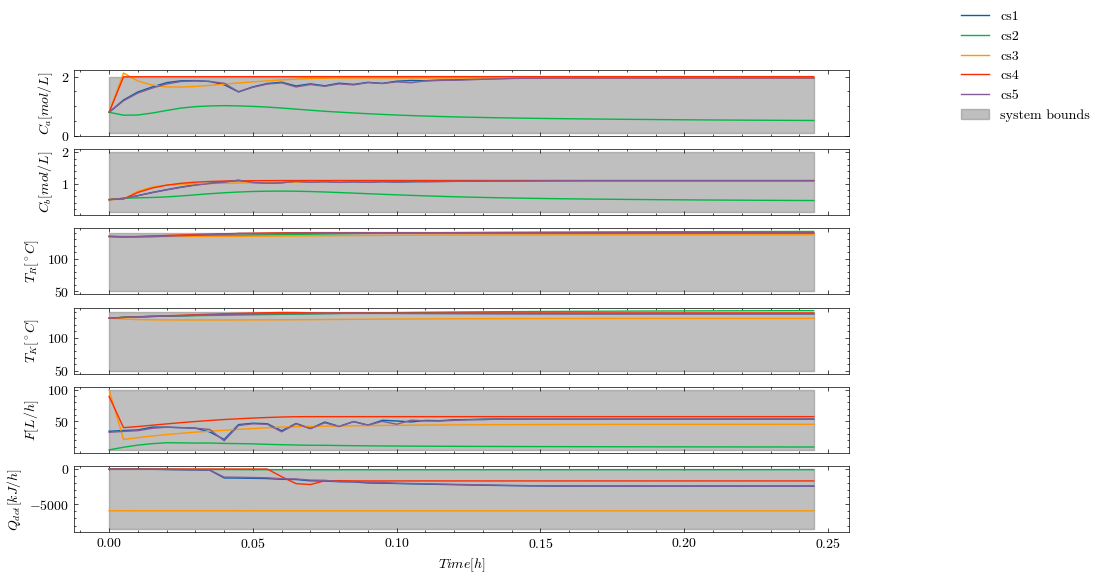

In [34]:
dm.combine_plots(system=cstr_system, figsize=(10, 6), fig_name='r1_combined.pdf')
# y_limit_down=[1.75, 1.75, None, None, None, None, None], y_limit_up=[2.25, 2.25, None, None, None, None, None]

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_datamanager.py:1653: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



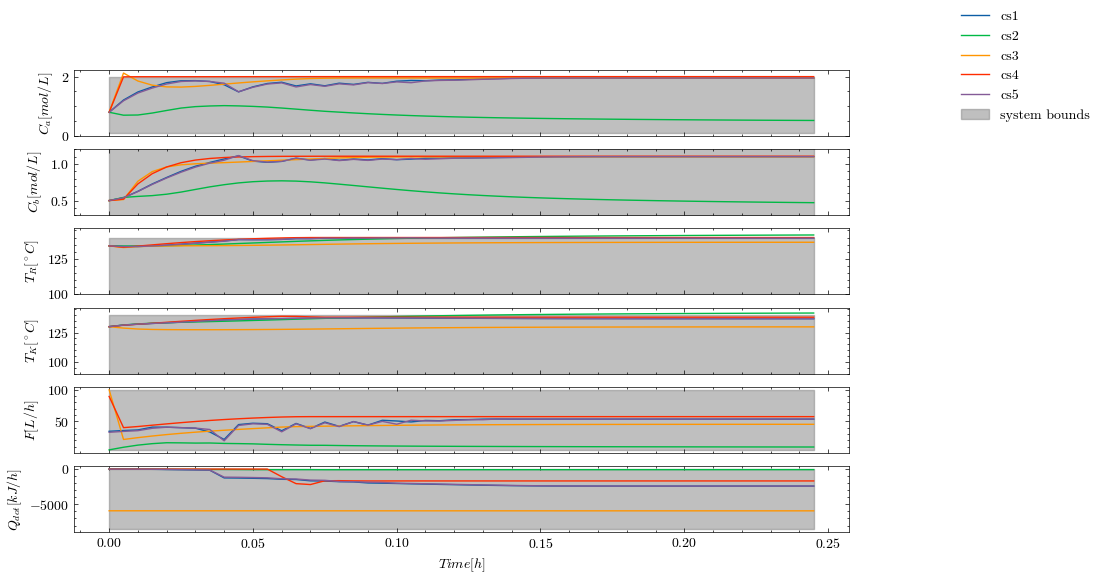

In [35]:
dm.combine_plots(system=cstr_system, figsize=(10, 6), y_limit_down=[None, 0.3, 100, 90, None, None, None], y_limit_up=[None, 1.2, None, None, None, None, None], fig_name='r1_combined_zoom.pdf')